# Let's build our first ANN!

Steps involved:

- Select and preprocess data (select variables/features, normalize and/or standardize, split train and test data)
- Select model architecture and hyperparameters- Start training your model
- Track the training loss and validationeat.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import keras
import sklearn

2024-02-22 15:06:46.327447: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9360] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-22 15:06:46.327495: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-22 15:06:46.327518: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1537] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-22 15:06:46.334887: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### lets create some toy weather data to play with

In [2]:
np.random.seed(123)

# set the time range from 1999-2019
times = pd.date_range("1999-01-01", "2019-12-31", name="time")

# create an "annual cycle"
annual_cycle = np.sin(2 * np.pi * (times.dayofyear.values / 365.25 - 0.28))

# create some base "temperatures"
base = 10 + 15 * annual_cycle.reshape(-1, 1)
tmin_values = base + 3 * np.random.randn(annual_cycle.size, 1)
tmax_values = base + 10 + 3 * np.random.randn(annual_cycle.size, 1)

# let's put these dummy temperatures into an xarray dataset
ds = xr.Dataset(
    {
        "tmin": (("time", "location"), tmin_values),
        "tmax": (("time", "location"), tmax_values),
    },
    {"time": times, "location": ["IA"]},
)

In [3]:
# what does this look like
ds

<xarray.Dataset>
Dimensions:   (time: 7670, location: 1)
Coordinates:
  * time      (time) datetime64[ns] 1999-01-01 1999-01-02 ... 2019-12-31
  * location  (location) <U2 'IA'
Data variables:
    tmin      (time, location) float64 -8.037 -1.83 -4.011 ... -4.857 -1.792
    tmax      (time, location) float64 9.607 7.746 -1.154 ... 4.474 10.84 7.317

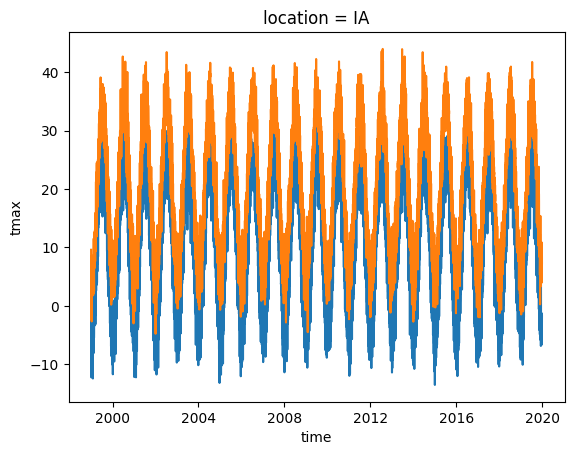

In [4]:
# some time series plots
ds.tmin.plot()
ds.tmax.plot()
plt.show()

### lets now preprocess our dataset in preparation for training

- Lets structure the supervised learning problem (what is the input/feature(s)/label?)
- Since this is time series data and there is autocorrelation, we will split data into train and test set using years rather than randomly splitting data
- Standardize and normalize the training set

In [5]:
ds

<xarray.Dataset>
Dimensions:   (time: 7670, location: 1)
Coordinates:
  * time      (time) datetime64[ns] 1999-01-01 1999-01-02 ... 2019-12-31
  * location  (location) <U2 'IA'
Data variables:
    tmin      (time, location) float64 -8.037 -1.83 -4.011 ... -4.857 -1.792
    tmax      (time, location) float64 9.607 7.746 -1.154 ... 4.474 10.84 7.317

Training and testing split by years

In [6]:
train = ds.sel(time=slice('1999-01-01T00:00:00.000000000','2014-12-31T00:00:00.000000000'))
test = ds.sel(time=slice('2015-01-01T00:00:00.000000000','2019-12-31T00:00:00.000000000'))

For random train test splitting, check out `from sklearn.model_selection import train_test_split`

Now lets set up the input and label.

In [7]:
input_train = train.tmin
label_train = train.tmax

And finally, let's go ahead and min-max scale our training data. We can levarage the sklearn function that will save our min and max values from the training set for us. 

In [8]:
from sklearn.preprocessing import MinMaxScaler

In [9]:
# create our scaler object
scaler_input = MinMaxScaler()
scaler_label = MinMaxScaler()

In [10]:
scaler_input.fit(input_train)

MinMaxScaler()

In [11]:
scaler_label.fit(label_train)

MinMaxScaler()

In [12]:
print(scaler_input.data_max_)
print(scaler_input.data_min_)

[33.52620933]
[-13.18084936]


In [13]:
print(scaler_label.data_max_)
print(scaler_label.data_min_)

[43.97570471]
[-4.77030373]


In [14]:
input_train_scaled = scaler_input.transform(input_train)
label_train_scaled = scaler_label.transform(label_train)

Let's confirm that this worked!

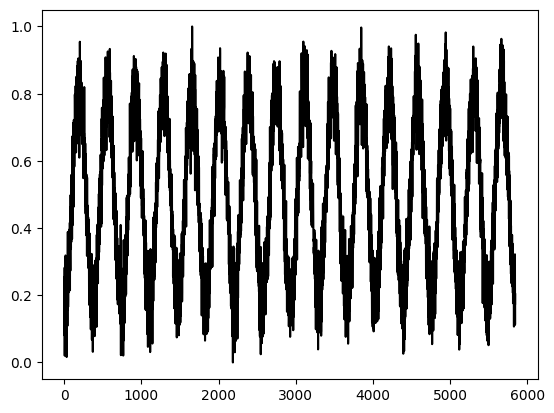

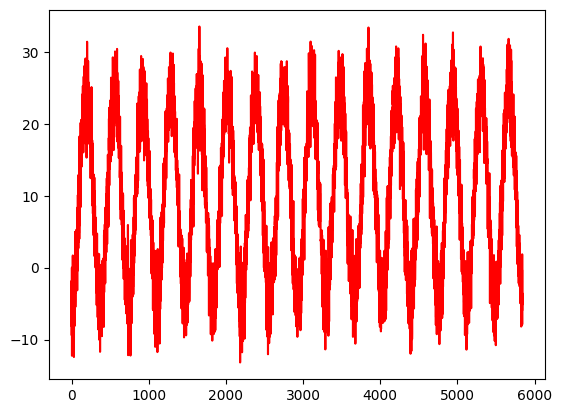

In [15]:
plt.plot(range(0,input_train_scaled.shape[0]), input_train_scaled, c='k')
plt.show()
plt.plot(range(0,input_train_scaled.shape[0]), input_train, c='r')
plt.show()

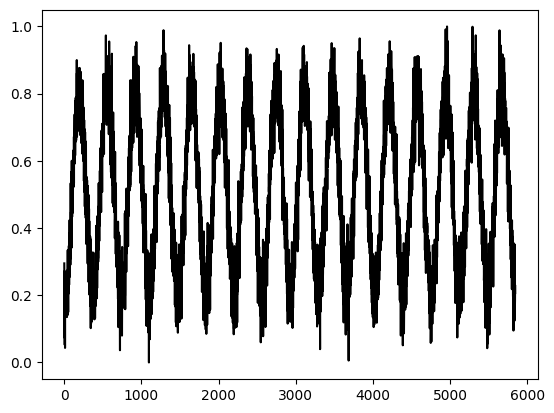

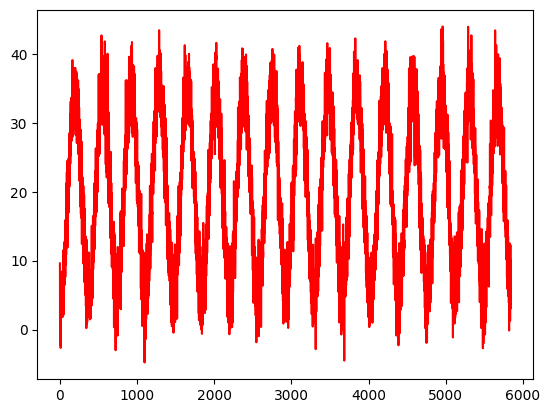

In [16]:
plt.plot(range(0,label_train_scaled.shape[0]), label_train_scaled, c='k')
plt.show()
plt.plot(range(0,label_train_scaled.shape[0]), label_train, c='r')
plt.show()

### Lets now build our ANN!

Documentation: https://keras.io/api/models/sequential/

In [17]:
model = keras.Sequential() # instantiate model object

Creating our input layer (not required, but I recommend this because it lets the model get built continuously as you are adding layers rather than waiting till the end to build).

In [18]:
model.add(keras.Input(shape=(1,), name="input_layer"))

Docs: https://keras.io/api/layers/core_layers/input/

Now lets add our hidden layers

In [19]:
model.add(keras.layers.Dense(units=8, activation=keras.activations.relu))
model.add(keras.layers.Dense(units=8, activation=keras.activations.relu))

2024-02-22 15:06:50.386499: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-22 15:06:50.386872: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-22 15:06:50.386989: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Docs: https://keras.io/api/layers/core_layers/dense/

Since this is a regression task, let's let the last layer be a single output value (per sample) with linear activation (aka `None`).

In [20]:
model.add(keras.layers.Dense(units=1))

Now compiling our model. We will use gradient descent (with momentum) optimizer called SGD and MSE as a loss function.

For more options and docs, see: 
- https://keras.io/api/optimizers/
- https://keras.io/api/losses/

In [21]:
model.compile(optimizer='sgd', loss='mse')

What does our model "look" like?

In [22]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 8)                 │         16 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_1 (Dense)                 │ (None, 8)                 │         72 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_2 (Dense)                 │ (None, 1)                 │          9 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 97 (388.00 B)

 Trainable params: 97 (388.00 B)

 Non-trainable params: 0 (0.00 B)

Call `model.fit` to train! Easy :) 

Documentation: https://keras.io/api/models/model_training_apis/

In [23]:
history = model.fit(    
    x=input_train_scaled,
    y=label_train_scaled,
    batch_size=32,
    epochs=20,
    verbose='auto',
    validation_split=0.1,
    validation_data=None,
    shuffle=True,
    class_weight=None,
    sample_weight=None,
    initial_epoch=0,
)

Epoch 1/20


2024-02-22 15:06:54.506348: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f87b8004650 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-22 15:06:54.506382: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): GRID A100X-10C, Compute Capability 8.0
2024-02-22 15:06:54.517994: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-22 15:06:54.578303: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907


133/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0117  

2024-02-22 15:06:54.848378: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0111 - val_loss: 0.0076
Epoch 2/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0075 - val_loss: 0.0075
Epoch 3/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0074 - val_loss: 0.0075
Epoch 4/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0073 - val_loss: 0.0074
Epoch 5/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0071 - val_loss: 0.0074
Epoch 6/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0071 - val_loss: 0.0073
Epoch 7/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0076 - val_loss: 0.0073
Epoch 8/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0073 - val_loss: 0.0073
Epoch 9/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0075 - val_loss: 0.0074
Epoch 10/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0075 - val_loss: 0.0073
Epoch 11/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0075 - val_loss: 0.0073
Epoch 12/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.

Lets plot our training and validation loss curves.

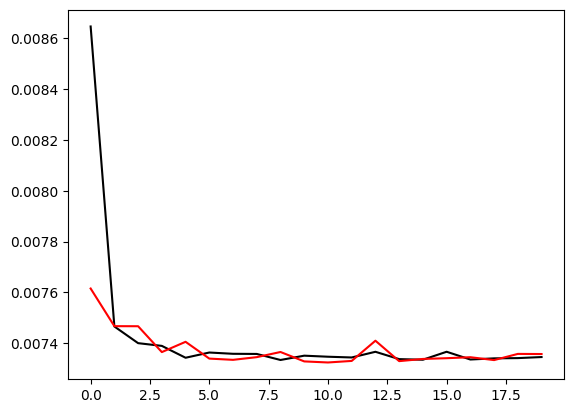

In [24]:
plt.plot(range(0,20), history.history['loss'], c='k')
plt.plot(range(0,20), history.history['val_loss'], c='r')
plt.show()

### Now lets do inference

How does our model perform on the testing set?

Rescale our test data using our earlier scaler objects

In [25]:
input_test = test.tmin
label_test = test.tmax

input_test_scaled = scaler_input.transform(input_test)
label_test_scaled = scaler_label.transform(label_test)

Quick double check!

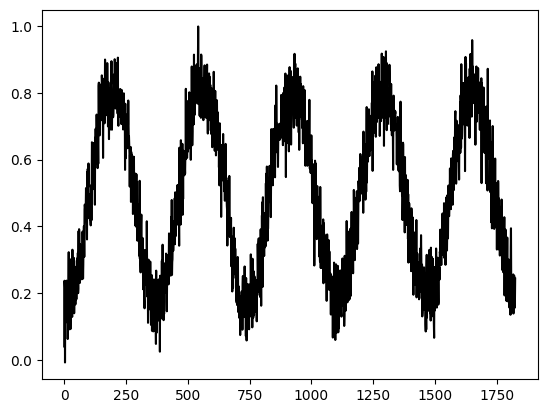

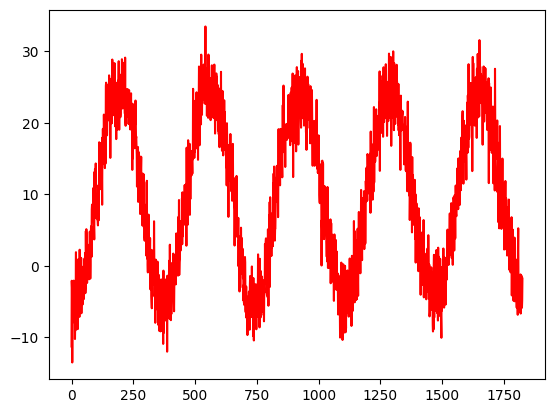

In [26]:
plt.plot(range(0,input_test_scaled.shape[0]), input_test_scaled, c='k')
plt.show()
plt.plot(range(0,input_test_scaled.shape[0]), input_test, c='r')
plt.show()

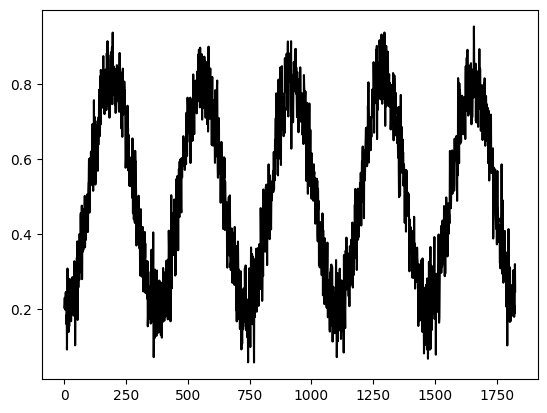

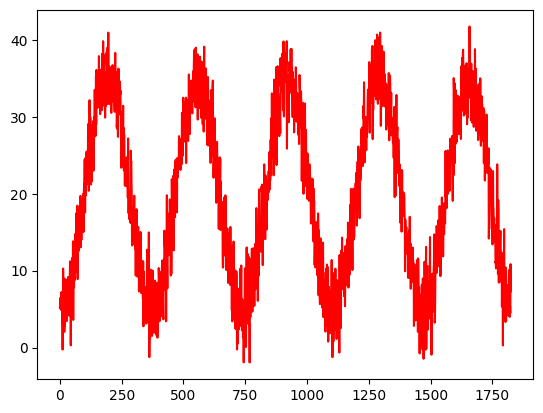

In [27]:
plt.plot(range(0,label_test_scaled.shape[0]), label_test_scaled, c='k')
plt.show()
plt.plot(range(0,label_test_scaled.shape[0]), label_test, c='r')
plt.show()

In [28]:
predictions = model.predict(
    x=input_test_scaled,
)

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


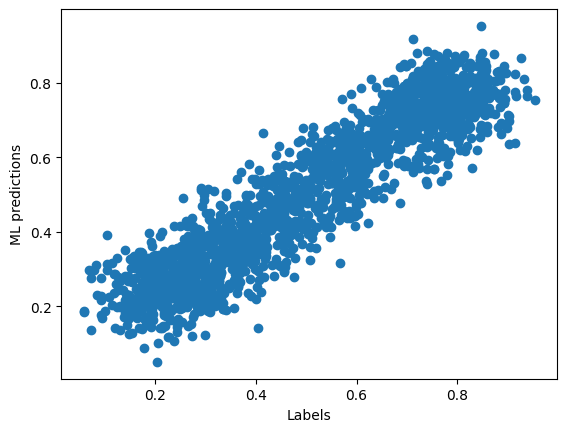

In [29]:
plt.scatter(label_test_scaled, predictions)
plt.xlabel('Labels')
plt.ylabel('ML predictions')
plt.show()

In [30]:
# MSE
# np.mean(square(y_true - y_pred))
np.mean(np.square(label_test_scaled - predictions))

0.00698919588799637